# Imports

In [1]:
# basics
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
# mlflow
import mlflow
# great expectations
import great_expectations as gx
# termcolor
from termcolor import colored

# MLFlow Experiment

FIRST: 
1. open ***mlflow ui*** via terminal

In [2]:
# Create a new experiment
experiment_name = "MLOps Project"

# create new experiment if not existing
try:
    mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)
# if experiment already exists, set experiment
except:
    mlflow.set_experiment(experiment_name)

In [3]:
# get experiment id
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

# Load Data

In [4]:
dataframe = pd.read_csv('Data/smoke_detection.csv', index_col=[0])

# Split Data

To simulate multiple datasets we're going to order the dataset bei the *UTC* column and split it into 3 equal parts

In [5]:
def split_dataframe(dataframe=dataframe):
    # order dataframe by month
    dataframe = dataframe.sort_values(by='UTC').reset_index(drop=True)
    
    # split dataframe into 3 equal sized datasets
    dataframe_1 = dataframe.iloc[:int(len(dataframe)/3)]
    dataframe_2 = dataframe.iloc[int(len(dataframe)/3):int(len(dataframe)/3)*2]
    dataframe_3 = dataframe.iloc[int(len(dataframe)/3)*2:]
    
    return dataframe_1, dataframe_2, dataframe_3

In [6]:
# pandas dataframes
df1, df2, df3 = split_dataframe(dataframe)

# EDA

In [7]:
print(f'Rows: {df1.shape[0]}\nColumns: {df1.shape[1]}')

Rows: 20876
Columns: 15


In [8]:
# first look at the data
df1.sample(5)

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
6202,1654733789,25.047,56.93,0,400,12777,19795,939.818,0.27,0.32,1.80,0.339,0.042,458,0
12615,1654740202,-5.740,50.62,237,400,13130,20035,939.639,0.48,0.50,3.30,0.514,0.012,6871,1
19562,1654747149,18.574,47.42,1164,510,12847,19448,938.885,1.88,1.95,12.94,2.017,0.046,13818,1
13573,1654741160,-4.092,50.44,291,400,13114,19966,939.428,0.46,0.48,3.15,0.491,0.011,7829,1
10668,1654738255,-7.997,53.78,18,400,13252,20193,939.662,2.25,2.33,15.46,2.410,0.054,4924,1


In [9]:
# descriptive statistics, data types and missing values
def dataset_infos(dataframe):
    # descriptive statistics
    descriptives = dataframe.describe(include='all').T

    # data types column
    descriptives.insert(loc=0, column='dtype', value=dataframe.dtypes)
    
    # missing values
    missing = pd.concat([dataframe.isnull().sum(), dataframe.eq('').sum()], keys=['nulls','empty strings'], axis=1)
    
    return pd.merge(descriptives, missing, left_index=True, right_index=True)

dataset_infos(df1)

,dtype,count,mean,std,min,25%,50%,75%,max,nulls,empty strings
UTC,int64,20876.0,1.654734e+09,12154.941397,1.654712e+09,1.654717e+09,1.654738e+09,1.654743e+09,1.654748e+09,0,0
Temperature[C],float64,20876.0,1.445650e+01,16.777181,-9.276000e+00,-4.094000e+00,1.693150e+01,2.637800e+01,5.993000e+01,0,0
Humidity[%],float64,20876.0,4.826455e+01,9.486005,1.074000e+01,4.700000e+01,5.015000e+01,5.336000e+01,7.520000e+01,0,0
TVOC[ppb],int64,20876.0,2.311279e+03,9539.882264,0.000000e+00,6.700000e+01,2.220000e+02,1.027000e+03,6.000000e+04,0,0
eCO2[ppm],int64,20876.0,6.927393e+02,1925.904927,4.000000e+02,4.000000e+02,4.000000e+02,5.090000e+02,3.918500e+04,0,0
Raw H2,int64,20876.0,1.295284e+04,318.702438,1.066800e+04,1.279400e+04,1.286800e+04,1.315100e+04,1.380300e+04,0,0
Raw Ethanol,int64,20876.0,1.990383e+04,683.249922,1.531700e+04,1.948400e+04,1.997600e+04,2.019125e+04,2.141000e+04,0,0
Pressure[hPa],float64,20876.0,9.387859e+02,1.004823,9.366240e+02,9.375470e+02,9.390970e+02,9.396340e+02,9.398610e+02,0,0
PM1.0,float64,20876.0,1.130871e+02,950.738240,0.000000e+00,7.600000e-01,1.820000e+00,2.160000e+00,1.334669e+04,0,0
PM2.5,float64,20876.0,1.936200e+02,1864.035040,0.000000e+00,8.000000e-01,1.890000e+00,2.240000e+00,4.126298e+04,0,0


In [10]:
# duplicate rows
print(f'Duplicated Rows: {df1.duplicated().sum()}')

Duplicated Rows: 0


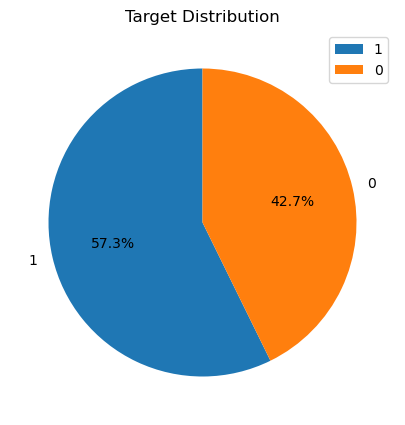

In [11]:
# plot target distribution (pie chart)
def plot_target_distribution(dataframe, target='Fire Alarm'):
    plt.figure(figsize=(10,5))
    plt.pie(dataframe[target].value_counts(), labels=dataframe[target].value_counts().index, autopct='%1.1f%%', startangle=90)
    plt.title('Target Distribution')
    plt.legend()
    plt.show()

plot_target_distribution(df1)

# Preprocessing

In [12]:
x, y = df1.drop(columns=['Fire Alarm']), df1['Fire Alarm']

In [13]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, stratify=y,random_state=420)

In [14]:
def preprocessing(data):
  '''
  Preprocessing function
  Input: dataframe
  Output: transformed data
  '''

  run_name = "preprocessing"

  # preprocessing pipeline
  pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])
    
  # Search for preprocessing run
  run = mlflow.search_runs(experiment_ids=experiment_id, filter_string=f"tags.mlflow.runName = '{run_name}'")
  # get run id
  run_id = run.iloc[0].run_id if not run.empty else None

  # if preprocessing-run does not exist
  if run.empty:
    # fit & transform pipeline
    data_preprocessed = pipeline.fit_transform(data)
    # start run
    with mlflow.start_run(run_name=run_name) as run:
      # log pipeline
      mlflow.sklearn.log_model(pipeline, 'pipeline')
      # end run
      mlflow.end_run()
    
  # if preprocessing-run exists
  else:
    # load pipeline
    pipeline = mlflow.sklearn.load_model(f'runs:/{run_id}/pipeline')
    # transform data
    data_preprocessed = pipeline.transform(data)
    
  return data_preprocessed

In [15]:
# preprocess training data
xtrain_prepro = preprocessing(xtrain)

2023/05/19 21:00:12 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [16]:
# preprocess test data
xtest_prepro = preprocessing(xtest)

# Modelling

## Training Multiple Classifiers

In [17]:
# fit prediction model on train dataset
def training(
    xtrain = xtrain_prepro,
    ytrain = ytrain,
    xtest = xtest_prepro,
    ytest = ytest,
    clf = {
        'Logistic Regression': LogisticRegression(random_state=420),
        'Decision Tree': DecisionTreeClassifier(random_state=420),
        'Random Forest': RandomForestClassifier(random_state=420)
        }):

    run_name = "training (basic)"

    # start run
    with mlflow.start_run(run_name=run_name) as run:
        # train given classifiers
        for clf_name, clf_val in clf.items():
            # initialize model
            model = clf_val
            # fit model to training data
            model.fit(xtrain_prepro, ytrain)
            # predict on test data
            ypred = model.predict(xtest_prepro)
            # log model accuracy
            mlflow.log_metric(f'accuracy_{clf_name}', accuracy_score(ytest, ypred))
            # log model precision
            mlflow.log_metric(f'precision_{clf_name}', precision_score(ytest, ypred))
            # log model recall
            mlflow.log_metric(f'recall_{clf_name}', recall_score(ytest, ypred))
            # log model f1-score
            mlflow.log_metric(f'f1_score_{clf_name}', f1_score(ytest, ypred))
            # log model
            mlflow.sklearn.log_model(model, f'model_{clf_name}')
            # print classification report
            print(f'Classification Report {clf_name}:\n\n{classification_report(ytest, ypred)}\n\n')
        # end run
        mlflow.end_run()

In [18]:
training()

Classification Report Logistic Regression:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1784
           1       1.00      1.00      1.00      2392

    accuracy                           1.00      4176
   macro avg       1.00      1.00      1.00      4176
weighted avg       1.00      1.00      1.00      4176



Classification Report Decision Tree:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1784
           1       1.00      1.00      1.00      2392

    accuracy                           1.00      4176
   macro avg       1.00      1.00      1.00      4176
weighted avg       1.00      1.00      1.00      4176



Classification Report Random Forest:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1784
           1       1.00      1.00      1.00      2392

    accuracy                           1.00      4176
   m

## GridSearchCV

In [19]:
def grid_search(
    xtrain = xtrain_prepro,
    ytrain = ytrain,
    xtest = xtest_prepro,
    ytest = ytest,
    clf = RandomForestClassifier(random_state=420),
    param_grid = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
        }):

    run_name = "grid search"

    # start run
    with mlflow.start_run(run_name=run_name) as run:
        # initialize grid search
        grid = GridSearchCV(clf, param_grid, cv=5, scoring='f1', n_jobs=-1)
        # fit grid search
        grid.fit(xtrain, ytrain)
        # predict on test data
        ypred = grid.predict(xtest)
        # log model accuracy
        mlflow.log_metric(f'grid_search_accuracy', accuracy_score(ytest, ypred))
        # log model precision
        mlflow.log_metric(f'grid_search_precision', precision_score(ytest, ypred))
        # log model recall
        mlflow.log_metric(f'grid_search_recall', recall_score(ytest, ypred))
        # log model f1-score
        mlflow.log_metric(f'grid_search_f1_score', f1_score(ytest, ypred))
        # log model
        mlflow.sklearn.log_model(grid, 'grid_search_model')
        # log best parameters
        mlflow.log_param('best_params', grid.best_params_)
        # print classification report
        print(f'Classification Report:\n\n{classification_report(ytest, ypred)}\n\n')
        # end run
        mlflow.end_run()

In [20]:
grid_search()

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1784
           1       1.00      1.00      1.00      2392

    accuracy                           1.00      4176
   macro avg       1.00      1.00      1.00      4176
weighted avg       1.00      1.00      1.00      4176





## Train Model with GridSearchCV-Parameters and all Training Data

In [21]:
def train_best_model(x, y):
    
    run_name = "training (optimal)"

    # Search for grid search run
    run = mlflow.search_runs(experiment_ids=experiment_id, filter_string=f"tags.mlflow.runName = 'grid search'")
    # get grid search parameters
    grid_params = ast.literal_eval(run.iloc[0]['params.best_params'])

    # start run
    with mlflow.start_run(run_name=run_name) as run:
        # get grid search parameters
        params = grid_params
        # initialize model
        model = RandomForestClassifier(**params, random_state=420)
        # fit model
        model.fit(x, y)
        # log model
        mlflow.sklearn.log_model(model, 'model (optimal)')
        # print model logged
        print('Optimal model logged...')
        # end run
        mlflow.end_run()

In [22]:
# combine training and test data
x = np.concatenate((xtrain_prepro, xtest_prepro), axis=0)
y = np.concatenate((ytrain, ytest), axis=0)

In [23]:
train_best_model(x, y)

Optimal model logged...


## Prediction

In [24]:
def predict_new_data(x, y):
    dataframe_name = [i for i in globals() if globals()[i] is x][0]
    # name of run (name of dataframe)
    run_name = f"predict {dataframe_name}"
    # search "model (optimal)" run
    run = mlflow.search_runs(experiment_ids=experiment_id, filter_string=f"tags.mlflow.runName = 'training (optimal)'")
    # get run id
    run_id = run.iloc[0].run_id if not run.empty else None
    # load model (optimal)
    model = mlflow.sklearn.load_model(f'runs:/{run_id}/model (optimal)')

    # start run
    with mlflow.start_run(run_name=run_name) as run:
        # predict on new data
        ypred = model.predict(x)
        # log model accuracy
        mlflow.log_metric(f'{dataframe_name}_accuracy', accuracy_score(y, ypred))
        # log model precision
        mlflow.log_metric(f'{dataframe_name}_precision', precision_score(y, ypred))
        # log model recall
        mlflow.log_metric(f'{dataframe_name}_recall', recall_score(y, ypred))
        # log model f1-score
        mlflow.log_metric(f'{dataframe_name}_f1_score', f1_score(y, ypred))
        # log parameters
        mlflow.log_param(f'{dataframe_name}_params', model.get_params())
        # log model
        mlflow.sklearn.log_model(model, f'{dataframe_name}_model')
        # print classification report
        print(f'Classification Report:\n\n{classification_report(y, ypred)}\n\n')
        # end run
        mlflow.end_run()

# Great Expectations

In [29]:
def great_expectations(check_dataframe, initial_dataframe=df1):

    initial_df = gx.dataset.PandasDataset(initial_dataframe)
    check_df = gx.dataset.PandasDataset(check_dataframe)
    
    # get column names from initial dataframe
    gx_columns = initial_df.get_table_columns()
    # get dtypes from initial dataframe
    gx_dtypes = initial_df.dtypes.apply(lambda x: str(x)).to_dict()

    # check if column are the same in all dataframes
    column_check = check_df.expect_table_columns_to_match_ordered_list(column_list=gx_columns)
    if column_check['success']:
        print('Columns Check: ', colored('OK', 'green'))
    else:
        print('Columns Check: ', colored('Failed', 'red'))

    # check if dtypes are the same in all dataframes
    check_set = set()
    for col, data_type in gx_dtypes.items():
        datatype_check = check_df.expect_column_values_to_be_of_type(column=col, type_=data_type)
        check_set.add(datatype_check['success'])
    if all(check_set) == True:
        print('Datatype Check: ', colored('OK', 'green'))
    else:
        print('Datatype Check: ', colored('Failed', 'red'))

    # check if dataframe has missing values
    check_set = set()
    for col in gx_columns:
        missing_values_check = check_df.expect_column_values_to_not_be_null(column=col)
        check_set.add(missing_values_check['success'])
    if all(check_set) == True:
        print('Missing Values Check: ', colored('OK', 'green'))
    else:
        print('Missing Values Check: ', colored('Failed', 'red'))

    # check if dataframe has duplicates
    duplicates_check = check_df.expect_table_row_count_to_be_between(min_value=check_df.shape[0], max_value=check_df.shape[0])
    if duplicates_check['success']:
        print('Duplicates Check: ', colored('OK', 'green'))
    else:
        print('Duplicates Check: ', colored('Failed', 'red'))

    # check if dataframe distribution is the same as in initial dataframe
    check_set = set()
    for col in gx_columns:
        distribution_check = check_df.expect_column_kl_divergence_to_be_less_than(column=col, partition_object={'values': initial_df[col].value_counts().index.tolist(), 'weights': initial_df[col].value_counts(normalize=True).tolist()}, threshold=0.6)
        check_set.add(distribution_check['success'])
    if all(check_set) == True:
        print('Distribution Check: ', colored('OK', 'green'))
    else:
        print('Distribution Check: ', colored('Failed', 'red'))

    # check if dataframe has outliers
    check_set = set()
    for col in gx_columns:
        outliers_check = check_df.expect_column_values_to_be_between(column=col, min_value=initial_df[col].min(), max_value=initial_df[col].max())
        check_set.add(outliers_check['success'])
    if all(check_set) == True:
        print('Outlier Check: ', colored('OK', 'green'))
    else:
        print('Outlier Check: ', colored('Failed', 'red'))

# Dataset 2

In [30]:
great_expectations(check_dataframe=df2, initial_dataframe=df1)

Columns Check:  OK
Datatype Check:  OK
Missing Values Check:  OK
Duplicates Check:  OK
Distribution Check:  Failed
Outlier Check:  Failed


In [31]:
df2_prepro, df2_y = preprocessing(df2.drop(columns=['Fire Alarm'])), df2['Fire Alarm']

In [32]:
predict_new_data(df2_prepro, df2_y)

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.04      0.08      3178
           1       0.85      1.00      0.92     17698

    accuracy                           0.85     20876
   macro avg       0.93      0.52      0.50     20876
weighted avg       0.88      0.85      0.79     20876





# Dataset 3

In [33]:
great_expectations(check_dataframe=df3, initial_dataframe=df1)

Columns Check:  OK
Datatype Check:  OK
Missing Values Check:  OK
Duplicates Check:  OK
Distribution Check:  Failed
Outlier Check:  Failed


In [34]:
df3_prepro, df3_y = preprocessing(df3.drop(columns=['Fire Alarm'])), df3['Fire Alarm']

In [35]:
predict_new_data(df3_prepro, df3_y)

Classification Report:

              precision    recall  f1-score   support

           0       0.39      0.13      0.19      5775
           1       0.73      0.93      0.82     15103

    accuracy                           0.70     20878
   macro avg       0.56      0.53      0.51     20878
weighted avg       0.64      0.70      0.65     20878



